## 使用 RNN 构建语言模型

In [2]:
# 运行环境
%load_ext watermark
%watermark -a 'Hugo' -v -m -d -p tensorflow,numpy,matplotlib

Hugo 2017-12-14 

CPython 3.6.2
IPython 6.1.0

tensorflow 1.3.0
numpy 1.13.3
matplotlib 2.1.0

compiler   : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system     : Darwin
release    : 17.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import jieba
from zhon.hanzi import punctuation

%matplotlib inline

## 语料预处理

In [4]:
# 读取字数
read_size = 120000

# 读取文件
with open('../code/xiaobo.txt') as f:
    corpus = f.read(read_size)

In [5]:
END_PUNC = '。？！'  # 作为句子结束的符号
IGNORE = '\n “”" …《》〈〉()* \u3000 :（）'  # 忽略不计的符号

In [6]:
# 切分句子
sentences = []
sentence = []
for word in jieba.cut(corpus):
    if word not in IGNORE:
        sentence.append(word)
    if word in END_PUNC:
        sentences.append(sentence)
        sentence = []

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/g5/df85rhb10jb9qpw1wdlh0t_m0000gn/T/jieba.cache
Loading model cost 1.014 seconds.
Prefix dict has been built succesfully.


In [7]:
# 句首加 token
sentences = [['<s>'] + sen for sen in sentences]

In [8]:
# 得到最长句子长度
all_length = [len(line) for line in sentences]
max_length = max(all_length)

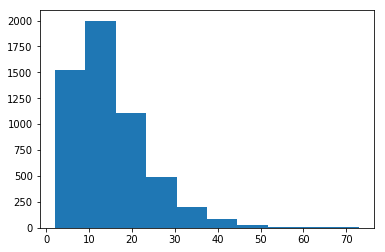

In [9]:
# 显示句子长度
plt.hist(all_length)
plt.show()

In [10]:
# 根据上图，令 max_length 等于 51
max_length = 51

In [11]:
len(sentences), max_length

(5443, 51)

In [12]:
# 句子末尾加 Pad
all_sentences = []
for sen in sentences:
    if len(sen) < max_length:
        sen = sen + ['<Pad>'] * (max_length - len(sen))
        all_sentences.append(sen)

In [13]:
# 统计词频
all_words = []
for words in all_sentences:
    for word in words:
        all_words.append(word)
    word_cnt = Counter(all_words)

In [14]:
# 建立词表，去掉词频小于 5 的词
vocab = ['UNK']
for i in word_cnt.most_common():
    if i[1] > 5:
        vocab.append(i[0])
    else:
        break
vocab_size = len(vocab)

In [15]:
vocab_size

1424

In [16]:
# 由词映射到序号的字典，可以用分词来查询，得到一个数字
idx_dict = dict(zip(vocab, range(vocab_size)))

In [17]:
# 将词列表转化成序号列表
indexs = []
for contents in all_sentences:
    index_content = []
    for word in contents:
        idx = idx_dict[word] if (word in vocab) else 0
        index_content.append(idx)
    indexs.append(index_content)

In [18]:
# 得到全部句子向量
sentences_vector = np.array(indexs)

In [18]:
# 获得训练数据
inputs_train = sentences_vector[:, :-1]
labels_train = sentences_vector[:, 1:]

In [19]:
inputs_train.shape, labels_train.shape

((5421, 50), (5421, 50))

## 构建 RNN 语言模型

In [20]:
# 重置 Graph
tf.reset_default_graph()

In [21]:
# 定义 LSTM Cell ,units = 128
cell = tf.contrib.rnn.GRUCell(128)
word_embedding_dim = 128

# 定义 word_embedding
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

# 定义 placeholder ，为了便于训练，更是为了生成句子，这里不固定维度
inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')
# 将 labels 打平
labels_flat = tf.reshape(labels, (-1,))

In [22]:
# look_up 得到词向量，格式是 look_up(w, input) ,格式需要是 int32，int64
input_embeds = tf.nn.embedding_lookup(word_embedding, inputs)

In [24]:
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, ?, 128) dtype=float32>

In [23]:
# 各句子中非零 id 的个数即为 sequence_length
sequence_length = tf.reduce_sum(tf.sign(inputs), axis=1) 
max_sequence_length = tf.reduce_max(sequence_length)

In [25]:
?tf.sign

In [69]:
# 执行 RNN 单元
output, states = tf.nn.dynamic_rnn(cell, input_embeds, dtype=tf.float32,
                                   sequence_length=sequence_length)

In [70]:
# 将 output 打平，shape = (None, 128)
output_flat = tf.reshape(output, (-1, 128))

In [71]:
# 定义 softmax 的 w,b
softmax_w = tf.Variable(tf.random_uniform([128, vocab_size]))
softmax_b = tf.Variable(tf.random_uniform([vocab_size]))

logits_flat = tf.matmul(output_flat, softmax_w) + softmax_b
probs_flat = tf.nn.softmax(logits_flat)
probs = tf.reshape(probs_flat, (-1, max_sequence_length, vocab_size))

# 定义损失函数
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_flat, labels=labels_flat))

In [72]:
# 用 mask 修正损失函数
mask = tf.cast(tf.sign(labels_flat), tf.float32)
cost = tf.reduce_sum(loss * mask)

In [73]:
# 定义优化器
train_step = tf.train.AdamOptimizer(0.001).minimize(cost)

In [74]:
# 模型参数设定
# Mini-batch Gradient Descent 设定 batch_size
batch_size = 20
feed_dict = {inputs: inputs_train, labels: labels_train}
max_steps = 100000

In [ ]:
# 创建会话，训练模型
sess = tf.Session()
sess.run(tf.global_variables_initializer())
feed_dict = {inputs: inputs_train, labels: labels_train}
arr = np.arange(len(labels_train))
costs = []
start = time.time()
try:
    for i in range(max_steps):
        np.random.shuffle(arr)
        for j in range(batch_size):
            batch_index = arr[j: j+batch_size] 
            batch_inputs = inputs_train[batch_index]
            batch_labels = labels_train[batch_index]
            batch_feed = {inputs: batch_inputs, labels: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
        if i % 5 == 0:
            loss = sess.run(cost, feed_dict=feed_dict)
            costs.append(loss)
            print("epoch: {:d}\tcost: {:.3f}".format(i, loss))
except KeyboardInterrupt:
    print('KeyboardInterrupt')
finally:
    end = time.time()
    print('\ntime: {:.2f} s'.format(end - start))

epoch: 0	cost: 567937.062
epoch: 5	cost: 469240.750
epoch: 10	cost: 452218.781
epoch: 15	cost: 446771.812
epoch: 20	cost: 437869.781
epoch: 25	cost: 435226.812
epoch: 30	cost: 427207.031
epoch: 35	cost: 428829.781
epoch: 40	cost: 418070.219
epoch: 45	cost: 414185.250
epoch: 50	cost: 407793.344
epoch: 55	cost: 405629.219
epoch: 60	cost: 400814.469
epoch: 65	cost: 401785.125
epoch: 70	cost: 396662.250
epoch: 75	cost: 392647.688
epoch: 80	cost: 389484.719
epoch: 85	cost: 385797.625
epoch: 90	cost: 382129.812
epoch: 95	cost: 377255.312
epoch: 100	cost: 375794.094
epoch: 105	cost: 373606.031
epoch: 110	cost: 373148.562
epoch: 115	cost: 367241.812
epoch: 120	cost: 363602.469
epoch: 125	cost: 361138.938
epoch: 130	cost: 356262.438
epoch: 135	cost: 361451.156
epoch: 140	cost: 358238.906
epoch: 145	cost: 351579.250
epoch: 150	cost: 349623.000
epoch: 155	cost: 346070.844
epoch: 160	cost: 344256.000
epoch: 165	cost: 340253.250
epoch: 170	cost: 340378.719
epoch: 175	cost: 334514.500
epoch: 180	cos

epoch: 1455	cost: 142736.828
epoch: 1460	cost: 143479.641
epoch: 1465	cost: 141320.500
epoch: 1470	cost: 138973.672
epoch: 1475	cost: 139369.672
epoch: 1480	cost: 138722.859
epoch: 1485	cost: 138955.625
epoch: 1490	cost: 138955.266
epoch: 1495	cost: 139481.594
epoch: 1500	cost: 140616.812
epoch: 1505	cost: 137971.641
epoch: 1510	cost: 137345.375
epoch: 1515	cost: 137882.641
epoch: 1520	cost: 139074.688
epoch: 1525	cost: 140454.250
epoch: 1530	cost: 139752.625
epoch: 1535	cost: 141506.859
epoch: 1540	cost: 139368.281
epoch: 1545	cost: 139223.781
epoch: 1550	cost: 137726.750
epoch: 1555	cost: 136749.547
epoch: 1560	cost: 135625.594
epoch: 1565	cost: 136093.359
epoch: 1570	cost: 136004.094
epoch: 1575	cost: 135608.562
epoch: 1580	cost: 135588.812
epoch: 1585	cost: 135632.688
epoch: 1590	cost: 135086.938
epoch: 1595	cost: 133843.109
epoch: 1600	cost: 134441.656
epoch: 1605	cost: 134447.125
epoch: 1610	cost: 135844.219
epoch: 1615	cost: 135976.203
epoch: 1620	cost: 133749.469
epoch: 1625	co

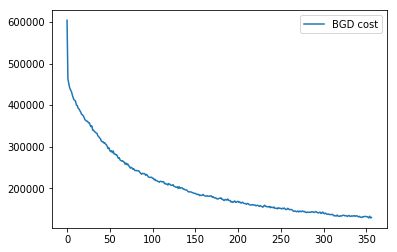

In [31]:
plt.plot(costs, label='BGD cost')
plt.legend()

## 用模型生成句子

In [32]:
# 特殊字符
VOCAB_SPECIAL = ('<s>', '<Pad>', 'UNK')

In [33]:
# 从 probs 中提取出下一个词的概率分布
probs_next_word = probs[0, -1, :]

In [34]:
# 词表 key 和 value 反转
idx_dict_reserver = dict((v,k) for k,v in idx_dict.items())

In [35]:
def get_sentence(start_words, top_words, sentence_length):
    # 得到句首 token
    word_ids = [idx_dict[start_words]]
    for i in range(sentence_length): 
        context = np.asarray(word_ids).reshape(1, -1)
        probs_val = sess.run(probs_next_word, feed_dict={inputs: context})

        top_words_indices = probs_val.argsort()[-top_words:][::-1]
        top_words_probs = [probs_val[i] for i in top_words_indices]

        for j in range(100): 
            # 根据已有词，生成下一个词
            # 从 top_words 概率最大的词中选择
            # 如果遇到了 <s> <Pad> UNK，就重新生成
            new_id = np.random.choice(top_words_indices, p=top_words_probs/sum(top_words_probs))
            new_word = idx_dict_reserver[new_id]
            if new_word not in VOCAB_SPECIAL:
                break
        word_ids.append(new_id)
        if new_word in END_PUNC:
            break
    sentence = [idx_dict_reserver[i] for i in word_ids]
    return ''.join(sentence[1:])

In [62]:
strart_words = '<s>' # 句首词
top_words=25 # 从概率最近的 top_words 里面取词
sentence_length = 100

for i in range(5):
    print("-----This is a %d sentence-----" %(i+1))
    print(get_sentence(strart_words, top_words, sentence_length))
    print("\n") 

-----This is a 1 sentence-----
当然叫这最后一口气想起儿给爸爸也就叫，这个送都知道穿什么这一步，到我就在你爸爸叫专门好不好也为他们想象不好？


-----This is a 2 sentence-----
有那明白我放牛走正路回家去从偷还要再问题没有！


-----This is a 3 sentence-----
那地方有两个家伙，是她想的书告诉主任说不跑到门口怀疑我很大裤子认为陈过来。


-----This is a 4 sentence-----
陈一下衣服很时说和王二还穿一辈子这样总倒下穿裤子谈话进来吧谈话时回来是路上面请，上面，不是给每每天下让好材料里出来斗争，看就是这样—如此好又往好好病人正看见。


-----This is a 5 sentence-----
忽然之间小时候来见很多蹲进纸算了也不不错听有你显得太太，别人看病现在跑去大知道是因为什么兴趣任何人。




In [37]:
# 保存模型
saver = tf.train.Saver()
saver.save(sess, '/Users/hugo/Save_models/lstm-model.ckpt', global_step=100)

'/Users/hugo/Save_models/lstm-model.ckpt-100'